In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyslaw.lineartheory import LinearModel
from pyslaw.visualization import midpointNormalize

# Analytical solution of the flow over the Witch of Agnesi hill

TODO:
- Add short description here (include author?)

Flow parameters

In [3]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape

In [4]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 100.0 # Height of the hill [m]

# Shape function of the hill
h = lambda x: hmax/(1+(x/L)**2)

Numerical parameters

In [5]:
Lx = 2000.0e3 # Length of the numerical domain [m]
Nx = int(1e5) # Number of grid points

Parameters for visualization

In [6]:
Lz = 15.0e3 # Height up to which solution is calculated [m]
Nz = 151    # Number of vertical levels to be used

## Solve flow problem

Create numerical grid

In [7]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 20.0 m


In [8]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 100.0 m


In [9]:
model = LinearModel(xs,h(xs),U,N)

In [10]:
%%time
eta = model.solve('eta',zs)

CPU times: user 859 ms, sys: 297 ms, total: 1.16 s
Wall time: 1.17 s


In [11]:
%%time
w = model.solve('w',zs)

CPU times: user 795 ms, sys: 250 ms, total: 1.05 s
Wall time: 1.07 s


## Visualization

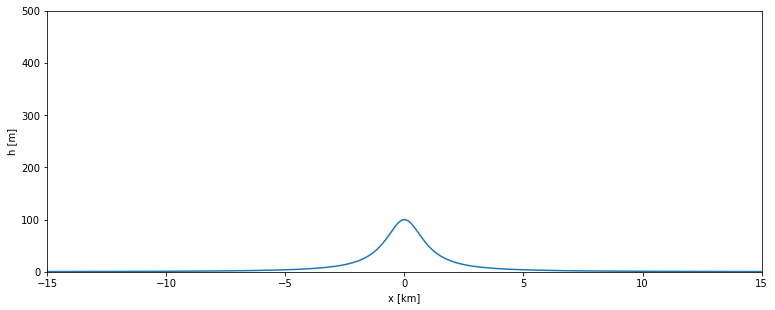

In [12]:
f,ax = plt.subplots(1,1,figsize=(12.8,4.8))
ax.plot(xs/1.e3,h(xs))
_ = ax.set(xlim=[-15,15],ylim=[0,500],xlabel='x [km]',ylabel='h [m]')

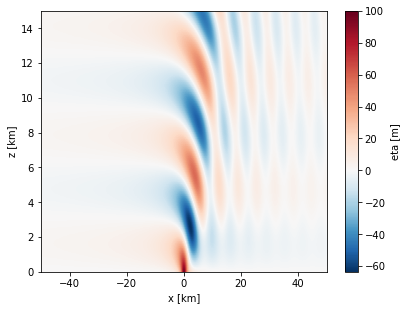

In [13]:
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))
im=ax.imshow(np.fliplr(eta).T,
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=midpointNormalize(midpoint=0))
cbar = f.colorbar(im,ax=ax,shrink=1.0,label='eta [m]')
_ = ax.set(xlim=[-50,50],xlabel='x [km]',ylabel='z [km]')

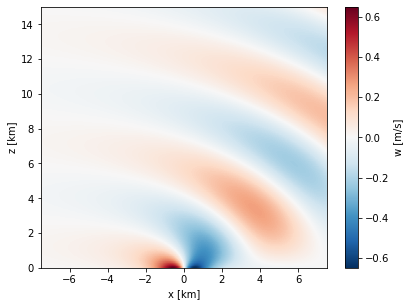

In [14]:
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))
im=ax.imshow(np.fliplr(w).T,
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=midpointNormalize(midpoint=0))
cbar = f.colorbar(im,ax=ax,shrink=1.0,label='w [m/s]')
_ = ax.set(xlim=[-7.5,7.5],xlabel='x [km]',ylabel='z [km]')